In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import similaritymeasures # python package that computes the Discrete Fréchet Distance between curves.

# PyTorch Requirements
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

## Visualise raw data

In [2]:
# Load and prepare data
data = pd.read_csv("../../data/cyclohexane.csv", header=0)

# raw data and best sample
X = data.drop("solvent", axis=1)
best_sample = X.iloc[0].to_numpy().reshape(-1, 1)

In [3]:
plt.rcParams['font.size'] = 12
xticks = np.linspace(0, X.shape[1]-1, 10, dtype=int)
xlabels = X.columns[xticks].astype(float).astype(int).values

def build_plot():
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.ylabel("Intensity (a.u)")
    plt.xlabel("Raman Shift (cm$^{-1}$)")
    plt.xlim([-20, 3296])
    plt.xticks(xticks, labels=xlabels)
    plt.grid(False)
    
    return fig

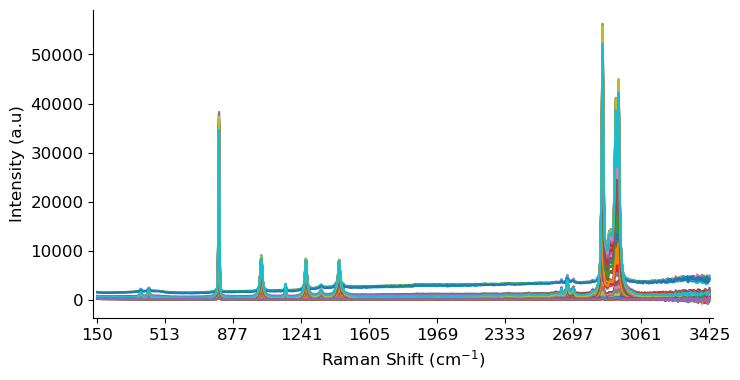

In [4]:
# Raw Spectra
_ = build_plot()
plt.plot(X.T);

# Create a Generative model

In [5]:
# Define separate models so we can save the Generator and discard the Discriminator later
class Generator(nn.Module):
    """
    Generator for 1D Raman signals
    Progressive convoutional upsampling until signal dimensionality is matched
    """
    def __init__(self, output_size: int = 3276):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # dimensions - (Batch, Channel_in, Width_in) i.e. input = [N, 1, 128]
            nn.ConvTranspose1d(in_channels=1, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(),

            nn.ConvTranspose1d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(),

            nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(),

            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(),

            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(),

            nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=4, stride=1, padding=0, bias=False), 
            nn.LeakyReLU(),

            nn.ConvTranspose1d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=0, bias=False), 
            nn.LeakyReLU(),

            nn.Linear(in_features=4101, out_features=output_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        # for layer in self.main:
        #     print(x.size())
        #     x = layer(x)
        # return x
        return self.main(x)

# Required parameters
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Z_DIM: int = 128

# define a new model
generator = Generator()

# Load the saved weights
generator.load_state_dict(torch.load("models/convolutional_gan_generator.pth"))
generator.to(DEVICE)
generator.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(1, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): ConvTranspose1d(16, 8, kernel_size=(4,), stride=(1,), bias=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): ConvTranspose1d(8, 1, kernel_size=(3,), stride=(1,), bias=False)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=4101, out_features=3276, bias=True)
  )
)

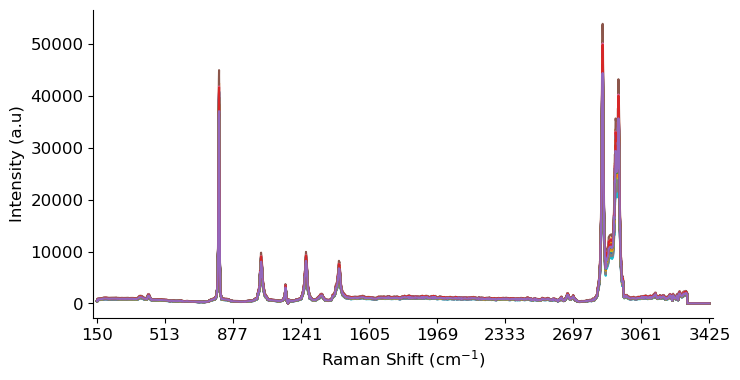

In [6]:
# Generate some samples
noise = torch.randn(145, 1, Z_DIM, device=DEVICE).detach()
synthetic_samples = generator(noise).detach().cpu().numpy().reshape(-1, 3276)

# make sure they are shaped the same
assert X.shape == synthetic_samples.shape

# New Synthetic spectra
_ = build_plot()
plt.plot(synthetic_samples.T);

## Mean, Median and Standard Deviation

Each wavelength is considered statistically independent, so when calculating statistics, we can compare them across the datasets and plot them for visual comparison. The results below indicate the generator is overfitting and suffered from mode collapse. The samples above are all very similar, and the mean, median and deviations are much higher when compared to the original dataset. However, it should be noted that preprocessing was not applied, and there is a large range difference between the measurements of the real samples. Training a GAN should be easier after applying preprocessing and cleaning the data.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Compute statistics for each dataset
X_mean = np.mean(X, axis=0)
X_median = np.median(X, axis=0)
X_deviation = np.std(X, axis=0)

synth_mean = np.mean(synthetic_samples, axis=0)
synth_median = np.median(synthetic_samples, axis=0)
synth_deviation = np.std(synthetic_samples, axis=0)

# make sure they are shaped the same
assert X_mean.shape == synth_mean.shape
assert X_median.shape == synth_median.shape
assert X_deviation.shape == synth_deviation.shape

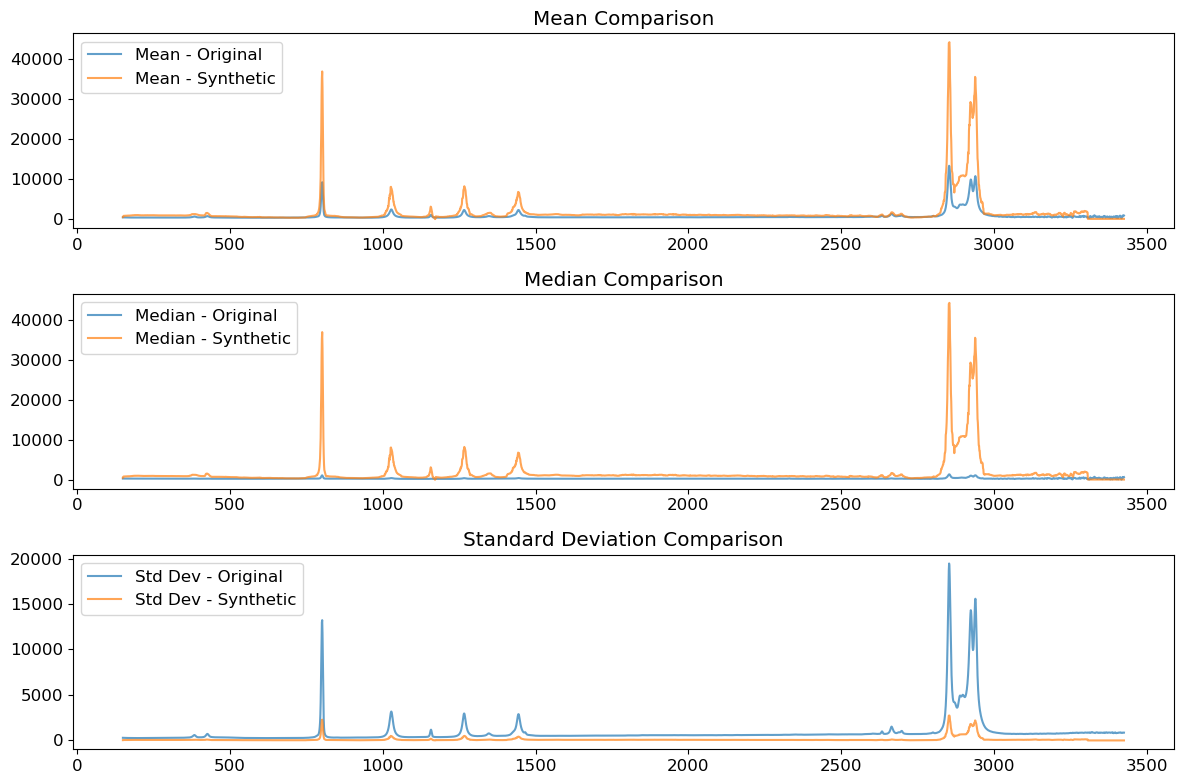

In [8]:
# Plot comparisons
xticks = X.columns.values.astype(float)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(xticks, X_mean, label='Mean - Original', alpha=0.7)
plt.plot(xticks, synth_mean, label='Mean - Synthetic', alpha=0.7)
plt.legend()
plt.title("Mean Comparison")

plt.subplot(3, 1, 2)
plt.plot(xticks, X_median, label='Median - Original', alpha=0.7)
plt.plot(xticks, synth_median, label='Median - Synthetic', alpha=0.7)
plt.legend()
plt.title("Median Comparison")

plt.subplot(3, 1, 3)
plt.plot(xticks, X_deviation, label='Std Dev - Original', alpha=0.7)
plt.plot(xticks, synth_deviation, label='Std Dev - Synthetic', alpha=0.7)
plt.legend()
plt.title("Standard Deviation Comparison")

plt.tight_layout()
plt.show()

## Discrete Fréchet Distance
The discrete Fréchet distance measures the similarity between curves by calculating the Euclidean distance between corresponding pair points along two parent signals (one real and one synthetic spectrum), and returns the maximum of all minimum distances required to traverse both curves. Here, we opt to compare the data using the mean of the original samples (across all wavelengths) and the mean of the synthetic samples. Larger values indicate dissimilarity between real and synthetic spectra, while smaller values suggest that the synthetic spectra effectively replicate real data. However, a dFid of zero would indicate perfect replication rather than meaningful variation, so additional metrics or algorithms may be required to assess whether the synthetic data introduces novel spectral variations, such as clustering via PCA demonstrated below.

In [9]:
X_dfid = X_mean.copy().to_numpy().reshape(-1, 1) # requires 2D array in shape (n_dimensions, 1)
synth_dfid = synth_mean.copy().reshape(-1, 1)

similaritymeasures.frechet_dist(X_dfid, synth_dfid)

31014.32781708816

## PCA

This demonstration further proves the lack of diveristy in the synthetic samples due to the mode collapse suffered by the GAN. The synthetic data contains very little variation among its own samples, and no characteristics from the original data.

In [10]:
X_pca = PCA(n_components=2)
X_pca_features = X_pca.fit_transform(X.to_numpy()) # to_numpy to remove index and feature names

synth_pca_features = X_pca.transform(synthetic_samples)
print(f"Number of PCs: {synth_pca_features.shape[1]}")

Number of PCs: 2


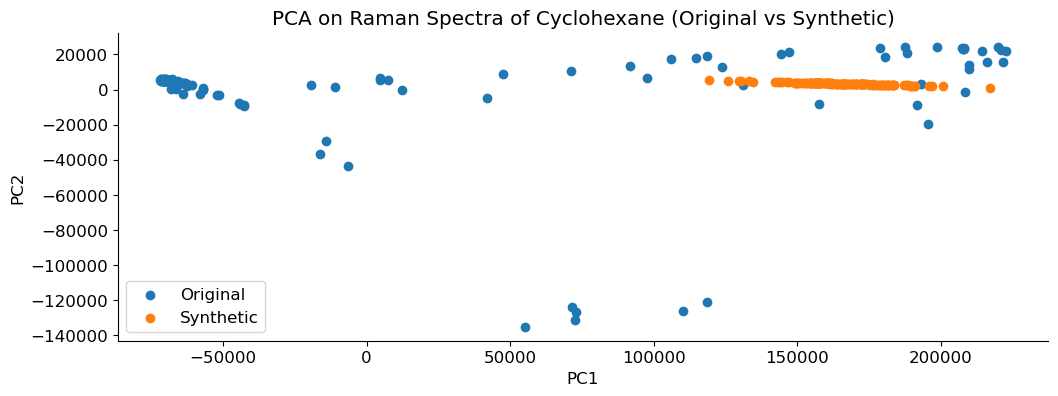

In [11]:
plt.figure(figsize=(12, 4))
plt.title("PCA on Raman Spectra of Cyclohexane (Original vs Synthetic)")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(False)

plt.scatter(X_pca_features[:, 0], X_pca_features[:, 1], label='Original')
plt.scatter(synth_pca_features[:, 0], synth_pca_features[:, 1], label='Synthetic')

plt.legend()

## t-SNE

Using t-Distributed Stochastic Neighbor Embedding (t-SNE) is a little harder to train and visualise the data due to it attempting to optimise a non-convex cost function based on the Kullback-Leibler (KL) divergence. It requires an iterative gradient descent approach, which can get stuck in local minima and requires careful hyperparameter tuning. Results can vary depending on initialisation and hyperparameter settings, making reproducibility challenging. Per the official Sklearn documentation, trying editing the perplexity between 5-50 and the learning rate between 10-1000 to see early indications of the randomness it introduces.

In [12]:
tsne_params = {
    "n_components": 2,
    "perplexity": 70.0,
    "early_exaggeration": 12.0,
    "learning_rate": "auto",
    "max_iter": 1000,
    "n_iter_without_progress": 300,
    "min_grad_norm": 1e-7,
    "metric": "euclidean",
    "metric_params": None,
    "init": "pca",
    "verbose": 0,
    "random_state": None,
    "method": "barnes_hut",
    "angle": 0.5,
    "n_jobs": None
}

X_tnse = TSNE(**tsne_params)
X_tnse_features = X_tnse.fit_transform(X.to_numpy()) # to_numpy to remove index and feature names

synth_tsne_features = X_tnse.fit_transform(synthetic_samples)
print(f"Number of PCs: {X_tnse_features.shape[1]}")

Number of PCs: 2


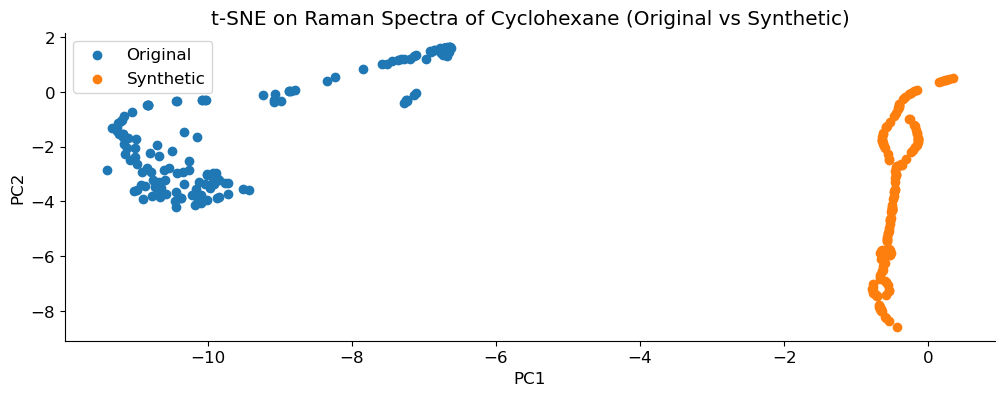

In [13]:
plt.figure(figsize=(12, 4))
plt.title("t-SNE on Raman Spectra of Cyclohexane (Original vs Synthetic)")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(False)

plt.scatter(X_tnse_features[:, 0], X_tnse_features[:, 1], label='Original')
plt.scatter(synth_tsne_features[:, 0], synth_tsne_features[:, 1], label='Synthetic')

plt.legend()